# Model Tuning BGG Data

This notbook is the sequal to "BGG_Scrape_Clean.ipynb". We will be performing EDA on the cleaned data, and fitting the best possible model to predict "How many average plays will a board game get"

In [1]:
import pickle

with open('bgg_df.pickle','rb') as read_file:
    df = pickle.load(read_file)

df.head()

,Rank,Name,BGG_Rating,AVG_Rating,Voter_Count,Min_Time,Min_Age,Difficulty,Avg_Plays,Plays_1,...,Plays_5,Plays_6,Plays_7,Plays_8,Plays_9,Plays_10,Plays_12,Plays_16,Plays_18,Plays_20
0,1,Gloomhaven,8.572,8.82,36196.0,60,14.0,3.8355,4.96,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Pandemic Legacy: Season 1,8.471,8.62,37811.0,60,13.0,2.8300,3.59,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Brass: Birmingham,8.291,8.64,13746.0,60,14.0,3.9209,1.63,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Terraforming Mars,8.280,8.43,56038.0,120,12.0,3.2357,4.09,1,...,1,0,0,0,0,0,0,0,0,0
4,5,Through the Ages: A New Story of Civilization,8.215,8.46,20639.0,120,14.0,4.4004,2.85,0,...,0,0,0,0,0,0,0,0,0,0


## EDA, Workflow, & Baseline Model

Note: "Avg_Plays" is the target

In [2]:
import pandas as pd
import seaborn as sns

### Full Heat Map of Correlations

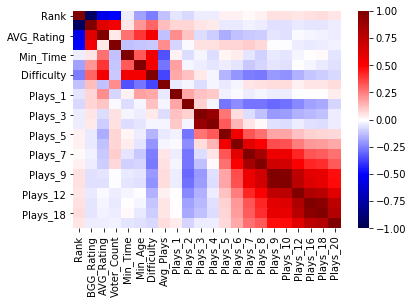

In [3]:
sns.heatmap(df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

- It seems there is a high correlation between the "player #s" that are close (Eg. 16-20, 9-12, and 7-8)
- The Rank and BGGRating are completely negatively correlated (higher rank (suckier game) = lower rating) and there are strong correlations between BGGRating, AVGRating, and Voter_Count
- Difficulty correlates with Min_Time and Min_Age :/

### Base Model - First Cross Validation

We're going to write a method that does a kfolds cross validation and prints the **R2s** of each fold, the **mean R2**, and the **val R2**. Then, well run it on our whole data set.

In [4]:
%load_ext autoreload
%autoreload 2

import model_selection as ms
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [5]:
# Holding out a test set
y_col = 'Avg_Plays'
testp=.2

X_og, y_og = df.drop(['Name', y_col], axis=1), df[y_col]
    
X, X_test, y, y_test = train_test_split(X_og, y_og, test_size=testp, random_state=10)

predicteds = ms.cross_val(X, y, dummy_idx=9)
_ = ms.cross_val(X, y, model=Ridge(alpha=1), name='Ridge', dummy_idx=9)
_ = ms.cross_val(X, y, model=LinearRegression(), poly=2, name='Polynomial', dummy_idx=9 )

Linear Regression Scores:  [0.22657481181221661, 0.2643041862921436, 0.23894902370377813, 0.3313268700047266, -0.02547627536696373, 0.30299559174977264, -0.05915746543332089, 0.19824026523827487, 0.24178142178367412, 0.1903185067448254] 

Linear.R. Train - Mean R^2: 0.258 +- 0.008
Linear.R. Val - Mean R^2: 0.191 +- 0.124

Coefficients:  [ 0.00058595  0.00513021 -0.00078929  0.00131986 -0.00219421 -0.00165468
 -0.0063265   0.00028422 -0.0002876  -0.00471333  0.00240995 -0.00209966
 -0.00237969  0.00029433 -0.00368841  0.00811466 -0.00180619 -0.01648844
 -0.00268437  0.016759    0.01497122]



Ridge Regression Scores:  [0.23141757074789737, 0.26959616682908594, 0.23348678525861066, 0.3369314772066684, -0.025120664322239028, 0.3042230664774215, -0.04029871848585831, 0.20108297711006684, 0.24182780638121093, 0.20378897713249622] 

Ridge.R. Train - Mean R^2: 0.257 +- 0.008
Ridge.R. Val - Mean R^2: 0.196 +- 0.121

Coefficients:  [ 6.04429066e-04  5.12070938e-03 -8.26247728e-04  1.32308575e-0

*Conclusion*
- The original fit is not so good. Looks like some underfitting.
- Polynomial at degree=2 looks like some overfitting, but I will try Lasso with Polynomial features.
- Ridge has a small effect on fixing the R^2. My intuition tells me more complexity first, though.

### Residuals and QQ Plot - Linear Assumptions

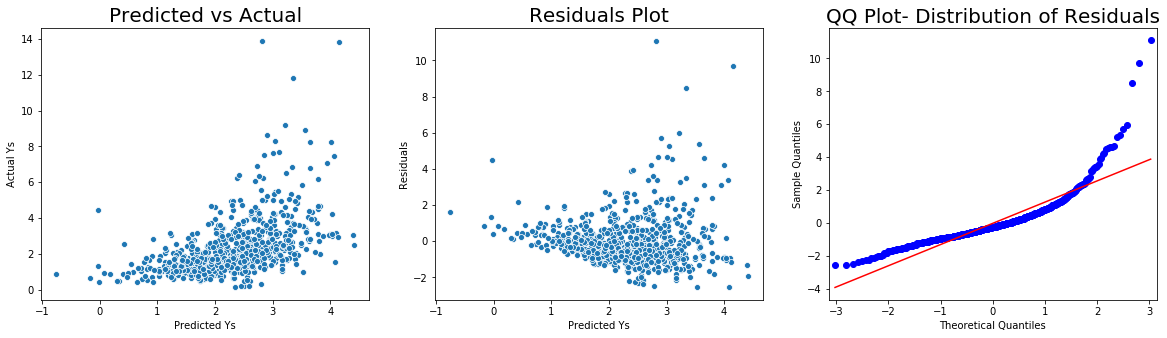

In [6]:
ms.analysis_plot(predicteds, y)

Note: The outer 2 graphs should be a straight line (left graph indicating the acuracy of the model, and right indicating normally distributed residuals) AND the middle graph should be random indicating ?

*Conclusion*
- The residual plot, and predicted vs actual plot, show quite a few outliers. The outliers will be investigated in the next section.
- In the residual plot, there seems to be heteroscedasticity indicating a variable needs to be transformed, or there is a variable missing.
- Looks like there are outliers on the QQplot... the image indicates "heavy skew" to the right which will be aparent in the next section.

[Resource 1](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/) "Reading Residual Plots"

[Resource 2](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot) "Interpreting QQ Plots"

### Distribution of Target Variable

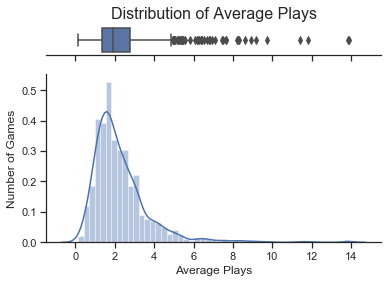

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(df['Avg_Plays'], ax=ax_box)
sns.distplot(df['Avg_Plays'], ax=ax_hist)

ax_box.set_title('Distribution of Average Plays', fontsize=16)
ax_box.set(yticks=[], xlabel=None)
ax_hist.set(xlabel='Average Plays', ylabel='Number of Games')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

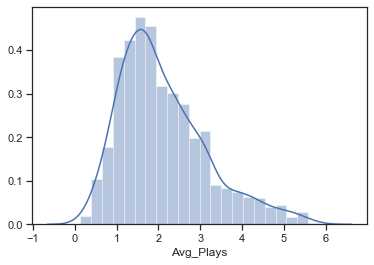

In [8]:
# Eliminating Some Outliers
# I use six based on where the box plot begins showing outliers
#  I could've used 5 but chose to be more conservative
mask = df['Avg_Plays'] < 6
sns.distplot(df[mask]['Avg_Plays']);

In [9]:
df[mask].shape

(972, 23)

*Conclusion*
- Consider eliminating some of those outliers (Only 2.8% of the data) or
- Gather more data.

### PairPlot & Correlations

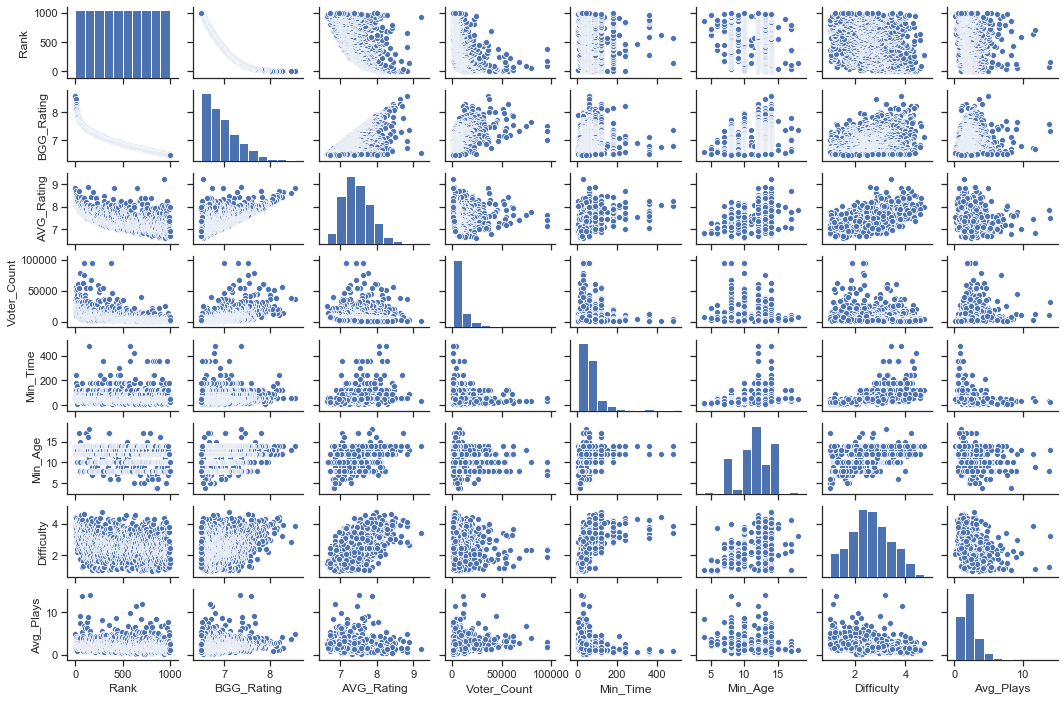

In [10]:
num_columns = ['Rank',
                'BGG_Rating',
                'AVG_Rating',
                'Voter_Count',
                'Min_Time',
                'Min_Age',
                'Difficulty',
                'Avg_Plays']

sns.pairplot(df[num_columns], height=1.2, aspect=1.5);

*Conclusion*
- Min_Time, Voter_Count, and BGG_Rating may have a log type distribution and possibly correlation. 
- Voter_Count and BGG_Rating may have a sqrt correlation. 
- The rest seem pretty linear if completely random. 



<h1 style="color:red;font-size = 20px;"><center><i>~~ Check Point ~~</i></center></h1>



## Model Tuning - Eliminating the Outliers

In [11]:
# eliminating 3% of the data (the outliers)
mask = y < 6
y2 = y[mask]
X2 = X[mask]

In [12]:
X2.shape

(776, 21)

In [13]:
# top model to show progress
_ = ms.cross_val(X2, y2, model=Lasso(alpha=.007), name='Lasso', dummy_idx=9)

Lasso Regression Scores:  [0.21152810686209178, 0.3628366132751082, 0.12848699450330436, 0.3769867999971257, 0.3435014548723889, 0.37697057981071824, 0.2095106178593239, 0.31383649567879135, 0.1382580065470781, 0.152118041770526] 

Lasso.R. Train - Mean R^2: 0.293 +- 0.012
Lasso.R. Val - Mean R^2: 0.261 +- 0.098

Coefficients:  [ 0.00000000e+00  3.93851703e-03 -1.49788296e-03  7.54095734e-04
 -1.69392677e-03 -1.72030830e-03 -4.10110863e-03  3.76599121e-04
 -6.64378104e-05  4.31939769e-06  0.00000000e+00 -8.07585227e-06
 -1.49327165e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]





In [14]:
X2.columns

Index(['Rank', 'BGG_Rating', 'AVG_Rating', 'Voter_Count', 'Min_Time',
       'Min_Age', 'Difficulty', 'Plays_1', 'Plays_2', 'Plays_3', 'Plays_4',
       'Plays_5', 'Plays_6', 'Plays_7', 'Plays_8', 'Plays_9', 'Plays_10',
       'Plays_12', 'Plays_16', 'Plays_18', 'Plays_20'],
      dtype='object')

WOAH! 26.1%, from 19.6%, is a pretty good improvement!

*Conclusion*
- Still some underfitting (probably because of afformentioned issues)
- It looks like if a game plays 7 or more people, it doesnt make a difference. The 'Rank' and 'Plays_4' columns got zerod out as well.


## Model Tuning - Feature Engineering 

After some trial and error and multiple polynomial regressions with different degrees combined with lasso regression with differnt aplpha values, I found that doing the following improves r^2 the most:
- adding *log* columns for min_time, and difficulty
- cubing the min_age column
- square rooting the voter_count
- performing lasso regression to cancel out any multicolinearity. 

In [15]:
# Features engineered 
X3 = X2.copy()
X3['Log_Time'] = np.log(X3['Min_Time'])
X3['Log_Diff'] = np.log(X3['Difficulty'])
X3['Age_Cubed'] = X3['Min_Age']**3
X3['Sqrt_VC'] = np.sqrt(X3['Voter_Count'])

In [16]:
# Top 2 models (after lots of trial and error)
predicteds2 = ms.cross_val(X3, y2, model=Lasso(alpha=.0075), poly=3, name='Polynomial/Lasso', dummy_idx=9 )#30.2
_ = ms.cross_val(X3, y2, model=Lasso(alpha=.005), name='Lasso', dummy_idx=9 ) #29.4

With Polynomial Features: degree = 3...

Polynomial/Lasso Regression Scores:  [0.25719687467797914, 0.3227309663715321, 0.26303911882565156, 0.4079497035495703, 0.4010822632799561, 0.38330514976602337, 0.17975673757996857, 0.36466206096768183, 0.1830451085544842, 0.253803296479007] 

Polynomial/Lasso.R. Train - Mean R^2: 0.367 +- 0.014
Polynomial/Lasso.R. Val - Mean R^2: 0.302 +- 0.082

Coefficients:  None



Lasso Regression Scores:  [0.2218681599308516, 0.3910774721741399, 0.19851060465234494, 0.4426942329382232, 0.38338324512472427, 0.39029072809532417, 0.17930697645191152, 0.3729814476054676, 0.15239004112439836, 0.20609054853083894] 

Lasso.R. Train - Mean R^2: 0.328 +- 0.013
Lasso.R. Val - Mean R^2: 0.294 +- 0.105

Coefficients:  [-2.65779291e-05  2.67353738e-03 -8.93272703e-04 -1.13277723e-03
  6.41167122e-04  4.60379682e-05  0.00000000e+00  2.38903155e-04
 -1.44674400e-04  3.81842646e-04  1.52556401e-04  3.31252123e-05
 -2.02787431e-03 -3.83615708e-05 -4.13467791e-04  0.0000000

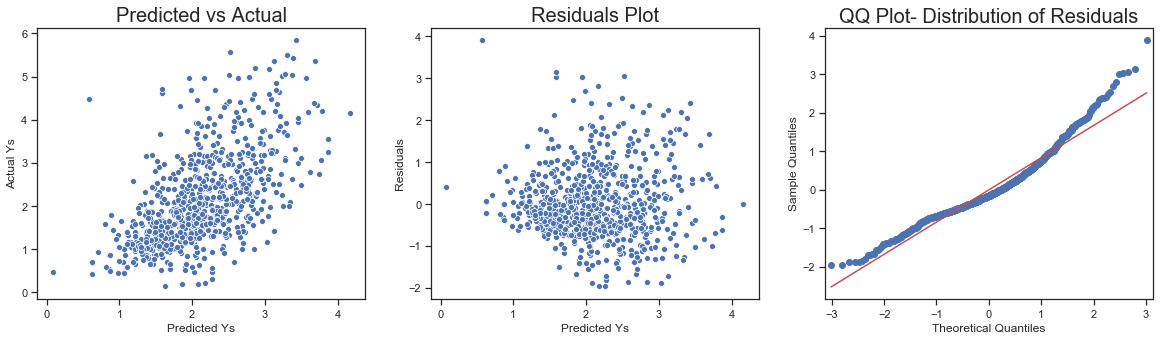

In [17]:
ms.analysis_plot(predicteds2, y2)

FINAL MODEL --> **Polynomial Features: Degree 3 w/ Lasso Regularization: alpha .0075** <--

r^2 = .302 !
 
*Conclusions*
- The graphs look a lot better (because of the elimination of outliers mainly)
- The first graph isnt as straight as I'd like, but the 2nd and 3rd graph are to my liking.

*Note*
Multicolinearity was considered, but the Lasso (on top of the Polynomial) fixed this issue.

## Final Analysis

In [18]:
# Note: X3 and y2 is the train set 

# 1. Use the same mask to eliminate outliers
mask_test = y_test < 6
y2_test = y_test[mask_test]
X2_test = X_test[mask_test]

X3_test = X2_test.copy()

# 2. Feature engineer the same features (in the same way)
X3_test['Log_Time'] = np.log(X3_test['Min_Time'])
X3_test['Log_Diff'] = np.log(X3_test['Difficulty'])
X3_test['Age_Cubed'] = X3_test['Min_Age']**3
X3_test['Sqrt_VC'] = np.sqrt(X3_test['Voter_Count'])

In [19]:
# 3. Polynomial(3), Lasso(.0075)
ms.train_test(X3, y2, X3_test, y2_test, model=Lasso(.0075), poly=3, scale=True, dummy_idx=9)

R^2: 0.30


# Appendix

In [20]:
# top 15 most played games
df.head(100).sort_values(by='Avg_Plays', ascending=False).head(5)

,Rank,Name,BGG_Rating,AVG_Rating,Voter_Count,Min_Time,Min_Age,Difficulty,Avg_Plays,Plays_1,...,Plays_5,Plays_6,Plays_7,Plays_8,Plays_9,Plays_10,Plays_12,Plays_16,Plays_18,Plays_20
67,68,Crokinole,7.590,7.86,11093.0,30,8.0,1.2609,13.85,0,...,0,0,0,0,0,0,0,0,0,0
50,51,Race for the Galaxy,7.658,7.76,44290.0,30,12.0,2.9796,9.19,0,...,0,0,0,0,0,0,0,0,0,0
48,49,Android: Netrunner,7.682,7.88,25886.0,45,14.0,3.3829,7.52,0,...,0,0,0,0,0,0,0,0,0,0
86,87,Dominion,7.523,7.63,74473.0,30,13.0,2.3592,6.78,0,...,0,0,0,0,0,0,0,0,0,0
68,69,Marvel Champions: The Card Game,7.587,8.25,6142.0,45,14.0,2.7586,5.27,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print('Target Variable Stats')
print('mean: ', df['Avg_Plays'].mean())
print('mode: ', df['Avg_Plays'].mode()[0])

Target Variable Stats
mean:  2.27802
mode:  1.79


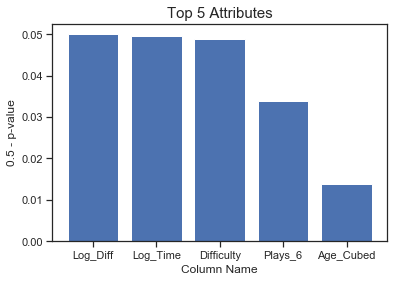

In [22]:
# Graph of the P values - Which attribute is most significant?

import statsmodels.regression.linear_model as sm
Xgraph = X3.copy()
Xgraph['Beta_0'] = 1

stats_model = sm.OLS(y2, Xgraph, data=df)
sm_results = stats_model.fit()

sig_pvalues = sm_results.pvalues[ sm_results.pvalues < .05 ].sort_values()
plt.bar(sig_pvalues.index, .05 - sig_pvalues.values)
plt.title('Top 5 Attributes', fontsize=15)
plt.xlabel('Column Name')
plt.ylabel('0.5 - p-value');

Some correlations:

1. Difficulty - as the game gets easier, the average # of plays exponentially and linearly increases 
2. Time - as the time it takes to play the game decreases, the average # of plays exponentially increases
3. 6 Players - having the game play 6 players can increase the average # of plays

In [23]:
# Table of the residuals - How off is the model?

graph = pd.DataFrame({'Actual': y2,
              'Predicted': predicteds2,
                'Residuals': (y2-predicteds2)})
rMSE = np.sqrt((graph['Residuals']**2).mean())
MAE = np.abs(graph['Residuals']).mean()

graph.head(10)

,Actual,Predicted,Residuals
188,2.59,2.806955,-0.216955
194,3.44,2.971965,0.468035
225,2.05,1.828615,0.221385
580,1.47,1.471913,-0.001913
244,1.28,1.496426,-0.216426
588,1.56,1.306232,0.253768
508,2.49,2.688127,-0.198127
966,1.58,2.154321,-0.574321
12,2.84,2.068558,0.771442
765,2.00,2.290001,-0.290001


In [24]:
print('Root MSE: ', rMSE) 
print('Mean Absolute Error: ', MAE)

Root MSE:  0.8369949143852544
Mean Absolute Error:  0.630306780709421


The residuals look good, and the rMSE looks okay, but a couple things to note...
- The target is number of plays a boardgame gets so being off by .6 could be the difference between predicting 4.4 (about 4 plays on average) and 5.0 (5 plays on average)
- That being said, for the goal of this project, that's not bad at all!

*Note:* this is **without** the final model (Polynomial(3), Lasso(.0075))